# Deep Learning for Fully Coupled FBSDE
## Based on "Three Algorithms for solving high-dimensional fully-coupled FBSDEs through deep learning" by Shaolin Ji, Shige Peng, Ying Peng et. al.

### Algorithm 1 (Algorithm 2 & 3 can use the same framework with slight modifications)

### Set up parameters

In [145]:
x0 = 1.0 # Initial value of X_t
T = 1 # Time horizon
N = 25 # Number of time points
dt = T / N # The length of the smallest time interval
M = 256 # Number of samples to calculate loss function (batch size)
eta = 0.005 # Learning rate
max_step = 3000 # The maximum number of iterations

### Import and Build up Brownian Motion sample paths

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

# Create M sample paths of BM, only record Delta B_t, store N increments at each time point for each BM
Delta_BM = torch.tensor(np.random.normal(0,np.sqrt(dt),size = (M,N)))

### Build up all coefficients in FBSDE

In [147]:
# Drift coeff of FSDE
def b(t,x,y,z):
    return -0.5 * torch.sin(t + x) * torch.cos(t + x) * (y ** 2 + z)

# Diffusion coeff of FSDE
def sigma(t,x,y,z):
    return 0.5 * torch.cos(t + x) * (y * torch.sin(t + x) + z + 1)

# Driver of BSDE
def f(t,x,y,z):
    return y * z - torch.cos(t + x)

# Terminal condition of BSDE
def g(T,x):
    return torch.sin(T + x)

### Build up neural networks and set up optimizer

In [148]:
# Set up NN
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # 4-layer NN, 2-dim input layer, 2 hidden layers with 12-dim and 1 output layer with 1-dim
        self.net = nn.Sequential(
            nn.Linear(2,12),
            nn.Sigmoid(),
            nn.Linear(12,12),
            nn.Sigmoid(),
            nn.Linear(12,12),
            nn.Sigmoid(),
            nn.Linear(12,1)
        )
    def forward(self,x):
        return self.net(x)
    
# Assign initial values, Y_init considered parameter so we need to track its gradient
Y_init = torch.tensor(0.0)
Y_init.requires_grad = True
X_init = torch.tensor(x0)

# Create a list of NN
NN_list = list()
param_list = list()
for ind in range(N - 1):
    NN = Model()
    NN_list.append(NN)
    param_list = param_list + list(NN.parameters())

# Add Y_init as parameter
param_list = param_list + [Y_init]

# Set up the optimizer
opt = torch.optim.SGD(param_list,lr = eta)

### Training Loop

In [149]:
# Loss history
loss_history = list()
# Y_init history
Y_init_history = list()

# Record X and Y, length equal to batch size
X_hat = torch.empty(M,dtype = torch.float32)
Y_hat = torch.empty(M,dtype = torch.float32)
next_X_hat = torch.empty(M,dtype = torch.float32)
next_Y_hat = torch.empty(M,dtype = torch.float32)

# Iteration count
for k in range(max_step):
    # Do M times of simulations to approximate the loss function by Monte Carlo, use a batch of size M in practice
    # so we don't need to run the NN for a lot of times repeatedly
    
    # Assign initial values
    X_hat = X_init * torch.ones(M)
    Y_hat = Y_init * torch.ones(M)
    
    # At the i-th time point
    for i in range(N - 1):
        # Predict Z by NN, prepare input of NN
        # First unsqueeze to turn 1-d tensor into 2-d
        unsq_X_hat = torch.unsqueeze(X_hat,1)
        unsq_Y_hat = torch.unsqueeze(Y_hat,1)
        
        # Concatenate to construct the input of NN
        XY_hat = torch.cat((unsq_X_hat,unsq_Y_hat),1)
        XY_hat = XY_hat.to(dtype = torch.float32) # Change the dtype       
        
        # Forward Propagation of NN
        Z_hat = NN_list[i](XY_hat)
        
        # Squeeze the output from 2-d tensor into 1-d
        sq_Z_hat = torch.squeeze(Z_hat)
        
        # The time now
        t = dt * i
        
        # Simulate X_hat
        next_X_hat = X_hat + b(t,X_hat,Y_hat,sq_Z_hat) * dt + sigma(t,X_hat,Y_hat,sq_Z_hat) * Delta_BM[:,i]
        
        # Simulate Y_hat
        next_Y_hat = Y_hat - f(t,X_hat,Y_hat,sq_Z_hat) * dt + sq_Z_hat * Delta_BM[:,i]
        
        # Update X_hat,Y_hat
        X_hat = next_X_hat
        Y_hat = next_Y_hat
        
        # Note: we CANNOT organize X_hat as a tensor with dimension max_step * M * N and record all simulation results
        # of X in the same tensor (although in disjoint regions). This is because Pytorch takes this as "in-place"
        # The definition of "in-place" operations: an operation that changes directly the content of a given Tensor 
        # without making a copy.
        # operation and this results in failures in tracking the gradient. Some other examples of "in-place" operations
        # are like "+=", "*=", however, "X = X + 1" is not considered "in-place".
        # Be careful with this point and always use "X_hat", "next_X_hat" scheme when training the NN.
            
    # Compute loss
    loss = torch.sum((Y_hat - g(T,X_hat)) ** 2) / (2 * M)
    
    # Print loss every 100 iterrations
    if k % 100 == 0:
        print('Iter: ' + str(k) + ', Loss: ' + str(loss.detach()))
        
    # Record loss and Y_init for plotting
    # Note: we shall clone after detaching
    loss_history.append(loss.detach().clone())
    Y_init_history.append(Y_init.detach().clone())
    
    # Back propagation
    opt.zero_grad()
    loss.backward()
    
    # Update NN parameters and Y_init
    opt.step()

Iter: 0, Loss: tensor(0.3431, dtype=torch.float64)
Iter: 100, Loss: tensor(0.1434, dtype=torch.float64)
Iter: 200, Loss: tensor(0.0759, dtype=torch.float64)
Iter: 300, Loss: tensor(0.0527, dtype=torch.float64)
Iter: 400, Loss: tensor(0.0423, dtype=torch.float64)
Iter: 500, Loss: tensor(0.0360, dtype=torch.float64)
Iter: 600, Loss: tensor(0.0314, dtype=torch.float64)
Iter: 700, Loss: tensor(0.0278, dtype=torch.float64)
Iter: 800, Loss: tensor(0.0250, dtype=torch.float64)
Iter: 900, Loss: tensor(0.0226, dtype=torch.float64)
Iter: 1000, Loss: tensor(0.0207, dtype=torch.float64)
Iter: 1100, Loss: tensor(0.0191, dtype=torch.float64)
Iter: 1200, Loss: tensor(0.0178, dtype=torch.float64)
Iter: 1300, Loss: tensor(0.0167, dtype=torch.float64)
Iter: 1400, Loss: tensor(0.0158, dtype=torch.float64)
Iter: 1500, Loss: tensor(0.0150, dtype=torch.float64)
Iter: 1600, Loss: tensor(0.0143, dtype=torch.float64)
Iter: 1700, Loss: tensor(0.0138, dtype=torch.float64)
Iter: 1800, Loss: tensor(0.0133, dtype=t

### Plot loss and error in $Y_0$

Text(0, 0.5, 'Loss')

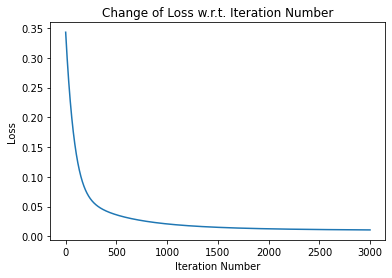

In [150]:
# Plot loss
plt.plot(range(max_step),loss_history)
plt.title('Change of Loss w.r.t. Iteration Number')
plt.xlabel('Iteration Number')
plt.ylabel('Loss')

Text(0, 0.5, 'Relative Error of $Y_0$')

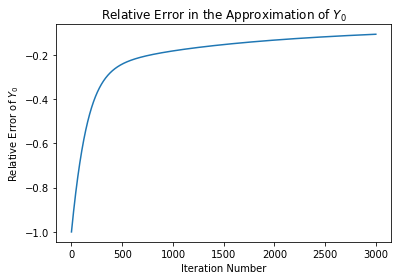

In [151]:
# Plot relative error in Y_0
true_Y_init = np.sin(1) # True Y_0 shall be sin(1+0) = sin(1)
plt.plot(range(max_step),(np.array(Y_init_history) - true_Y_init) / true_Y_init)
plt.title('Relative Error in the Approximation of $Y_0$')
plt.xlabel('Iteration Number')
plt.ylabel('Relative Error of $Y_0$')

### Test the result with a fixed Brownian Motion trajectory

In [152]:
# Fix one BM trajectory to create Xt,Yt,Zt, comparing to the true solution
Test_Delta_BM = torch.tensor(np.random.normal(0,np.sqrt(dt),size = N))

# Trajectory of three processes
Test_X = torch.empty(N,dtype = torch.float32)
Test_Y = torch.empty(N,dtype = torch.float32)
Test_Z = torch.empty(N,dtype = torch.float32)

# Assign initial values to X,Y
Test_X[0] = x0
Test_Y[0] = Y_init.detach().clone()

# Do simulations
for i in range(N - 1):
    # Prepare input for the NN
    unsq_Test_X = torch.unsqueeze(Test_X[0:1],1)
    unsq_Test_Y = torch.unsqueeze(Test_Y[0:1],1)
        
    # Concatenate to construct the input of NN
    XY_hat = torch.cat((unsq_Test_X,unsq_Test_Y),1)
    XY_hat = XY_hat.to(dtype = torch.float32)      

    # Forward Propagation, do not need to record gradient any longer
    with torch.no_grad():
        Test_Z_val = NN_list[i](XY_hat)
    sq_Test_Z_val = torch.squeeze(Test_Z_val)
    Test_Z[i] = sq_Test_Z_val
        
    # The time now
    t = dt * i
        
    # Simulate X_hat
    Test_X[i + 1] = Test_X[i] + b(t,Test_X[i],Test_Y[i],sq_Test_Z_val) * dt 
    + sigma(t,Test_X[i],Test_X[i],sq_Test_Z_val) * Test_Delta_BM[i]
        
    # Simulate Y_hat
    Test_Y[i + 1] = Test_Y[i] - f(t,Test_X[i],Test_Y[i],sq_Test_Z_val) * dt + sq_Test_Z_val * Test_Delta_BM[i]

### Plot the simulated version of $X_t$,$Y_t,Z_t$, compare with the closed-form solution

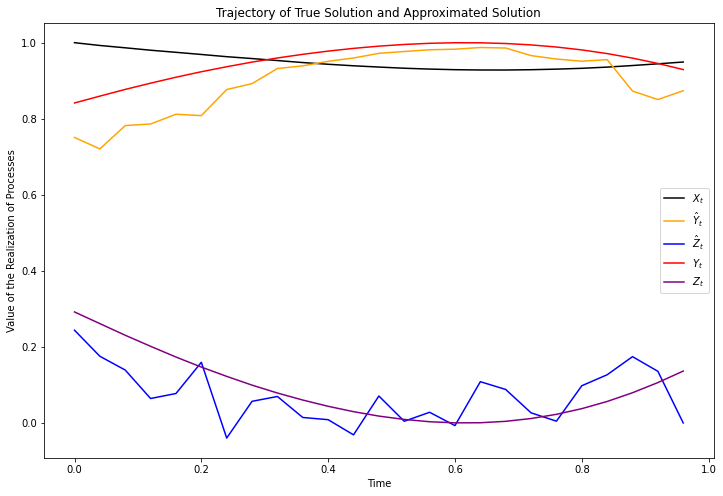

In [153]:
# Make a larger plot
plt.figure(figsize=(12,8))

# X-axis as time
plot_x = dt * np.array(range(N))

# Plot Xt
plt.plot(plot_x,Test_X.detach(),label = '$X_t$',color = 'black')

# Plot Yt approximated
plt.plot(plot_x,Test_Y.detach(),label = '$\hat{Y}_t$',color = 'orange')

# Plot Zt approximated
plt.plot(plot_x,Test_Z.detach(),label = '$\hat{Z}_t$',color = 'blue')

# Plot true Yt, Y_t = sin(t+Xt)
true_Y = torch.sin(torch.linspace(0,T,N) + Test_X)
plt.plot(plot_x,true_Y.detach(),label = '$Y_t$',color = 'red')

# Plot true Zt, Z_t = cos^2(t+Xt)
true_Z = (torch.cos(torch.linspace(0,T,N) + Test_X)) ** 2
plt.plot(plot_x,true_Z.detach(),label = '$Z_t$',color = 'purple')

# Legends
plt.title('Trajectory of True Solution and Approximated Solution')
plt.xlabel('Time')
plt.ylabel('Value of the Realization of Processes')
plt.legend()